In [790]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from torch import optim, nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb


import copy
%matplotlib inline

rng = 0

test_values = pd.read_csv("./test-set-values.csv")
train_values = pd.read_csv("./training-set-values.csv")
train_labels = pd.read_csv("./training-set-labels.csv")


In [791]:
print("columns:")
print(train_values.columns.values)
print()
print(train_values.info())

columns:
['id' 'amount_tsh' 'date_recorded' 'funder' 'gps_height' 'installer'
 'longitude' 'latitude' 'wpt_name' 'num_private' 'basin' 'subvillage'
 'region' 'region_code' 'district_code' 'lga' 'ward' 'population'
 'public_meeting' 'recorded_by' 'scheme_management' 'scheme_name' 'permit'
 'construction_year' 'extraction_type' 'extraction_type_group'
 'extraction_type_class' 'management' 'management_group' 'payment'
 'payment_type' 'water_quality' 'quality_group' 'quantity'
 'quantity_group' 'source' 'source_type' 'source_class' 'waterpoint_type'
 'waterpoint_type_group']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 


In [792]:
train_values.iloc[:, :20].describe(include='all')

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by
count,59400.000000,59400.000000,59400,55765,59400.000000,55745,59400.000000,5.940000e+04,59400,59400.000000,59400,59029,59400,59400.000000,59400.000000,59400,59400,59400.000000,56066,59400
unique,NaN,NaN,356,1897,NaN,2145,NaN,NaN,37400,NaN,9,19287,21,NaN,NaN,125,2092,NaN,2,1
top,NaN,NaN,2011-03-15,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Lake Victoria,Madukani,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd
freq,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,10248,508,5294,NaN,NaN,2503,307,NaN,51011,59400
mean,37115.131768,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,NaN,NaN,NaN,15.297003,5.629747,NaN,NaN,179.909983,NaN,NaN
std,21453.128371,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,NaN,NaN,NaN,17.587406,9.633649,NaN,NaN,471.482176,NaN,NaN
min,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN
25%,18519.750000,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,NaN,NaN,NaN,5.000000,2.000000,NaN,NaN,0.000000,NaN,NaN
50%,37061.500000,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,NaN,NaN,NaN,12.000000,3.000000,NaN,NaN,25.000000,NaN,NaN
75%,55656.500000,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,NaN,NaN,NaN,17.000000,5.000000,NaN,NaN,215.000000,NaN,NaN


In [793]:
train_values.iloc[:, 21:].describe(include='all')

,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,31234,56344,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,2696,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,682,38852,NaN,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,NaN,NaN,1300.652475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,951.620547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,1986.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [794]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [795]:
train_values.drop("num_private",axis=1,inplace=True)

In [796]:
d = {
    "date_recorded": "string",
    "funder": "string",
    "installer": "string",
    "wpt_name": "string",
    "basin": "string",
    "subvillage": "string",
    "region": "string",
    "lga": "string",
    "ward": "string",
    "public_meeting": "string",
    "recorded_by": "string",
    "scheme_management": "string",
    "scheme_name": "string",
    "permit": "string",
    "extraction_type": "string",
    "extraction_type_group": "string",
    "extraction_type_class": "string",
    "management": "string",
    "management_group": "string",
    "payment": "string",
    "payment_type": "string",
    "water_quality": "string",
    "quality_group": "string",
    "quantity": "string",
    "quantity_group": "string",
    "source": "string",
    "source_type": "string",
    "source_class": "string",
    "waterpoint_type": "string",
    "waterpoint_type_group": "string",
}
train_values= train_values.astype(d)
train_values["date_recorded"] = pd.to_datetime(
    train_values["date_recorded"],
    infer_datetime_format=True
)

train_labels.status_group = train_labels.status_group.astype('string')


print(train_values.date_recorded.describe())
print()
pd.to_datetime(train_values.date_recorded).describe(datetime_is_numeric=True)

count                   59400
unique                    356
top       2011-03-15 00:00:00
freq                      572
first     2002-10-14 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object



/tmp/ipykernel_144335/2943963355.py:42: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(train_values.date_recorded.describe())


count                            59400
mean     2012-03-29 09:11:33.818181888
min                2002-10-14 00:00:00
25%                2011-04-01 00:00:00
50%                2012-10-10 00:00:00
75%                2013-02-09 00:00:00
max                2013-12-03 00:00:00
Name: date_recorded, dtype: object

# Null and Nan checking

In [797]:
print("any nulls in train_values?")
print(pd.isnull(train_values).any()[lambda x: x == True])
print()
print("any NANs in train_values?")
print(pd.isna(train_values).any()[lambda x:x == True])


any nulls in train_values?
funder               True
installer            True
subvillage           True
public_meeting       True
scheme_management    True
scheme_name          True
permit               True
dtype: bool

any NANs in train_values?
funder               True
installer            True
subvillage           True
public_meeting       True
scheme_management    True
scheme_name          True
permit               True
dtype: bool


In [798]:
train_values.fillna("Unknown",inplace=True)

PS: The features not shown are false for both cases


### train_values have the same features with both NANs and nulls.

In [799]:
print("any nulls or NANs in train_labels?")
print(pd.isnull(train_labels).any())
print(pd.isna(train_labels).any())


any nulls or NANs in train_labels?
id              False
status_group    False
dtype: bool
id              False
status_group    False
dtype: bool


# Showing Values:

In [800]:
train_values.iloc[:, :20].head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,Unknown,GeoData Consultants Ltd,Other
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,Unknown


In [801]:
train_values.iloc[:, 21:40].head()


,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


# Showing unique values in cetain columns with fewer categories:

There are alot of "0" strings around the features, they will be imputed to be "Unknown" just like the nulls and Nans.

In [802]:
imputer = SimpleImputer(missing_values="0",fill_value="Unknown",strategy='constant')
temp = imputer.fit_transform(train_values)
train_values= pd.DataFrame(temp ,columns=train_values.columns)

In [803]:
print("Count of Unique funders: "+str(len(train_values.funder.unique())))
print()
print(train_values.funder.value_counts().head(20))


Count of Unique funders: 1896

Government Of Tanzania    9084
Unknown                   4416
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
Norad                      765
Germany Republi            610
Tcrs                       602
Ministry Of Water          590
Water                      583
Dwe                        484
Name: funder, dtype: int64


In [804]:
print("Count of unique installers: "+str(len(train_values.installer.unique())))
train_values.installer.value_counts().head(20)

Count of unique installers: 2144


DWE                   17402
Unknown                4435
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
LGA                     408
World vision            408
WEDECO                  397
TASAF                   396
District council        392
Name: installer, dtype: int64

In [805]:
train_values.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [806]:
train_values.subvillage.value_counts().head(20)

Madukani      508
Shuleni       506
Majengo       502
Kati          373
Unknown       371
Mtakuja       262
Sokoni        232
M             187
Muungano      172
Mbuyuni       164
Mlimani       152
Songambele    147
Msikitini     134
Miembeni      134
1             132
Kibaoni       114
Kanisani      111
I             109
Mapinduzi     109
Mjimwema      108
Name: subvillage, dtype: int64

In [807]:
train_values.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [808]:
train_values.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

Column with same data: GeoData Consultants Ltd.  
Not useful.

In [809]:
print(train_values.recorded_by.value_counts())
train_values.drop('recorded_by',inplace=True,axis=1)

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64


In [810]:
train_values[['scheme_management']].apply(pd.Series.value_counts)

,scheme_management
VWC,36793
WUG,5206
Unknown,3877
Water authority,3153
WUA,2883
Water Board,2748
Parastatal,1680
Private operator,1063
Company,1061
Other,766


In [811]:
train_values.scheme_name.value_counts().head(20)

Unknown                                  28166
K                                          682
None                                       644
Borehole                                   546
Chalinze wate                              405
M                                          400
DANIDA                                     379
Government                                 320
Ngana water supplied scheme                270
wanging'ombe water supply s                261
wanging'ombe supply scheme                 234
I                                          229
Bagamoyo wate                              229
Uroki-Bomang'ombe water sup                209
N                                          204
Kirua kahe gravity water supply trust      193
Machumba estate pipe line                  185
Makwale water supplied sche                166
Kijiji                                     161
S                                          154
Name: scheme_name, dtype: int64

In [812]:
train_values.permit.value_counts(())

True       38852
False      17492
Unknown     3056
Name: permit, dtype: int64

In [813]:
train_values.construction_year.value_counts().sort_values()

1966       17
1965       19
1961       21
1962       30
1964       40
1969       59
1968       77
1963       85
1967       88
1960      102
1971      145
2013      176
1973      184
1979      192
1977      202
1981      238
1987      302
1989      316
1991      324
1970      411
1976      414
1986      434
1975      437
1983      488
1988      521
2001      540
1993      608
1992      640
1997      644
1974      676
1972      708
1994      738
1982      744
1984      779
1996      811
1980      811
1985      945
1990      954
1998      966
1999      979
2005     1011
1995     1014
1978     1037
2002     1075
2012     1084
2004     1123
2011     1256
2003     1286
2006     1471
2007     1587
2000     2091
2009     2533
2008     2613
2010     2645
0       20709
Name: construction_year, dtype: int64

In [814]:
train_values[['extraction_type','extraction_type_group','extraction_type_class']].apply(pd.Series.value_counts)

,extraction_type,extraction_type_group,extraction_type_class
afridev,1770.0,1770.0,NaN
cemo,90.0,NaN,NaN
climax,32.0,NaN,NaN
gravity,26780.0,26780.0,26780.0
handpump,NaN,NaN,16456.0
india mark ii,2400.0,2400.0,NaN
india mark iii,98.0,98.0,NaN
ksb,1415.0,NaN,NaN
mono,2865.0,2865.0,NaN
motorpump,NaN,NaN,2987.0


In [815]:
# train_values['extraction'] = train_values.extraction_type+" "+train_values.extraction_type_group+" "+train_values.extraction_type_class
# train_values.drop(['extraction_type','extraction_type_group','extraction_type_class'],inplace=True,axis=1)


In [816]:
# for row in train_values:
#     print(row)
    # if row[['extraction_type']] == row[['extraction_type_group']]:
#     #     row["extraction"] = row.extraction_type +" "+row.extraction_type_class
#     # else:
#     #      row['extraction'] = row['extraction_type']+" "+row['extraction_type_group']+" "+row["extraction_type_class"]

# for i , row in train_values[['extraction_type','extraction_type_group','extraction_type_class']].iterrows():
#     if row[['extraction_type']][0] == row[['extraction_type_group']][0] and row['extraction_type'] == row['extraction_type_class']:
#         train_values.loc[i,"extraction"] = row.extraction_type
#     elif row['extraction_type'][0] == row[['extraction_type_group']][0] and row['extraction_type'] != row['extraction_type_class']:
#         train_values.loc[i,"extraction"] = row.extraction_type + row.extraction_type_class
#     elif row['extraction_type'][0] != row[['extraction_type_group']][0] and row['extraction_type'] == row['extraction_type_class']:
#         train_values.loc[i,"extraction"] = row.extraction_type + row.extraction_type_class
#     else:
#          train_values.loc[i,"extraction"] = row['extraction_type']+" "+row['extraction_type_group']+" "+row["extraction_type_class"]


# train_values['extraction'].sample(40)

In [817]:
# for i in range(train_values.shape[0]):
#     if train_values.loc[i,'extraction_type'] == train_values.loc[i,'extraction_type_group'] \
#         and train_values.loc[i,'extraction_type_group'] == train_values.loc[i,'extraction_type_class']:
#         train_values.loc[i,"extraction"] = train_values.loc[i,"extraction_type"]
#     elif train_values.loc[i,'extraction_type'] == train_values.loc[i,'extraction_type_group'] \
#     or train_values.loc[i,'extraction_type_group'] == train_values.loc[i,'extraction_type_class']:
#         train_values.loc[i,"extraction"] = train_values.loc[i,'extraction_type'] + " "+train_values.loc[i,'extraction_type_class']
#     else:
#          train_values.loc[i,"extraction"] = train_values.loc[i,'extraction_type']
#          +" "+train_values.loc[i,'extraction_type_group']
#          +" "+train_values.loc[i,"extraction_type_class"]


In [818]:
# train_values['extraction'].sample(100)

In [819]:
print(train_values[['management','management_group']].apply(pd.Series.value_counts))
train_values[['management','management_group']].sample(20)

                  management  management_group
commercial               NaN            3638.0
company                685.0               NaN
other                  844.0             943.0
other - school          99.0               NaN
parastatal            1768.0            1768.0
private operator      1971.0               NaN
trust                   78.0               NaN
unknown                561.0             561.0
user-group               NaN           52490.0
vwc                  40507.0               NaN
water authority        904.0               NaN
water board           2933.0               NaN
wua                   2535.0               NaN
wug                   6515.0               NaN


,management,management_group
54873,wug,user-group
5042,vwc,user-group
26401,vwc,user-group
54291,vwc,user-group
13328,wua,user-group
44992,wug,user-group
50017,vwc,user-group
16528,vwc,user-group
24339,vwc,user-group
2635,vwc,user-group


In [820]:
train_values[['payment','payment_type']].apply(pd.Series.value_counts)

,payment,payment_type
annually,NaN,3642.0
monthly,NaN,8300.0
never pay,25348.0,25348.0
on failure,NaN,3914.0
other,1054.0,1054.0
pay annually,3642.0,NaN
pay monthly,8300.0,NaN
pay per bucket,8985.0,NaN
pay when scheme fails,3914.0,NaN
per bucket,NaN,8985.0


In [821]:
print("Row counts that has both mentioned strings in their respective columns:")
print(train_values[(train_values.payment == 'pay monthly') & (train_values.payment_type == 'monthly')].shape[0])
print(train_values[(train_values.payment == 'pay annually') & (train_values.payment_type == 'annually')].shape[0])
print(train_values[(train_values.payment == 'pay per bucket') & (train_values.payment_type == 'per bucket')].shape[0])
print(train_values[(train_values.payment == 'pay when scheme fails') & (train_values.payment_type == 'on failure')].shape[0])




Row counts that has both strings in their respective columns:
8300
3642
8985
3914


From the cell above certain string pairs has the same meaning and row count coninsiding with both strings' value_counts from the previous cells.  
Eg: both 'pay monthly' and 'monthly' has the same counts.

There other strings with same counts in both 'payment' and 'payment_type'.

So one of the columns is redundant and seeing 'payment' column and the unique strings, it make less sense than 'payment types' and their unique strings. 

So I will drop 'payment'

In [822]:
train_values.drop('payment',inplace=True,axis=1)

In [ ]:
train_values[train_values.quality_group =='colored']

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,extraction
129,41839,0.0,2011-07-27,Hesawa,0,HESAWA,32.993701,-2.690442,Kwa Nhag,Lake Victoria,...,coloured,colored,dry,dry,shallow well,shallow well,groundwater,other,other,other
149,24232,0.0,2011-04-07,<NA>,0,<NA>,34.358400,-8.694247,Kwa Mzee Yakobo Kimela,Rufiji,...,coloured,colored,seasonal,seasonal,river,river/lake,surface,communal standpipe,communal standpipe,gravity
151,72981,0.0,2011-04-16,<NA>,0,<NA>,33.784219,-8.779946,Kwa Peter,Rufiji,...,coloured,colored,seasonal,seasonal,river,river/lake,surface,communal standpipe,communal standpipe,gravity
204,10068,0.0,2011-07-27,Jbg,0,JBG,30.499852,-2.555499,Kikoko,Lake Victoria,...,coloured,colored,insufficient,insufficient,spring,spring,groundwater,other,other,gravity
371,59102,7200.0,2013-03-17,Private Individual,1726,Dmdd,35.918349,-3.176927,Kwa Tiaini,Internal,...,coloured,colored,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,gravity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58824,66158,0.0,2011-02-26,Dhv,482,DWE,37.820519,-6.891484,Zahanati,Wami / Ruvu,...,coloured,colored,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,swn 80 handpump
58843,15127,0.0,2012-10-31,District Council,0,District council,32.108284,-5.108313,Mbugani,Lake Tanganyika,...,coloured,colored,enough,enough,shallow well,shallow well,groundwater,other,other,other
59146,58119,0.0,2013-03-02,Padep,1270,PADEP,36.868577,-5.887974,Bwawani,Wami / Ruvu,...,coloured,colored,enough,enough,dam,dam,surface,communal standpipe,communal standpipe,gravity
59151,70250,50.0,2011-02-27,Government Of Tanzania,206,Ce,38.584122,-6.373322,Tangini,Wami / Ruvu,...,coloured,colored,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,submersible


In [ ]:
# print(train_values[train_values.water_quality == 'coloured'])

print(train_values[['water_quality','quality_group']].apply(pd.Series.value_counts))

                    water_quality  quality_group
colored                      <NA>            490
coloured                      490           <NA>
fluoride                      200            217
fluoride abandoned             17           <NA>
good                         <NA>          50818
milky                         804            804
salty                        4856           5195
salty abandoned               339           <NA>
soft                        50818           <NA>
unknown                      1876           1876


In [654]:
print(train_values[['quantity','quantity_group']].apply(pd.Series.value_counts))
train_values[train_values.quantity == train_values.quantity_group].loc[:,'quantity'].count()

              quantity  quantity_group
enough           33186           33186
insufficient     15129           15129
dry               6246            6246
seasonal          4050            4050
unknown            789             789


59400

59400 is the number of rows in the dataset, so that means quantity series is exactly the same as quantity_group

In [386]:
train_values.drop('quantity_group',inplace=True,axis=1)

In [169]:
train_values[['source','source_type','source_class']].apply(pd.Series.value_counts)

,source,source_type,source_class
borehole,<NA>,11949,<NA>
dam,656,656,<NA>
groundwater,<NA>,<NA>,45794
hand dtw,874,<NA>,<NA>
lake,765,<NA>,<NA>
machine dbh,11075,<NA>,<NA>
other,212,278,<NA>
rainwater harvesting,2295,2295,<NA>
river,9612,<NA>,<NA>
river/lake,<NA>,10377,<NA>


In [173]:
train_values[['waterpoint_type','waterpoint_type_group']].apply(pd.Series.value_counts)

,waterpoint_type,waterpoint_type_group
cattle trough,116,116
communal standpipe,28522,34625
communal standpipe multiple,6103,<NA>
dam,7,7
hand pump,17488,17488
improved spring,784,784
other,6380,6380


In [514]:
train_values[['waterpoint_type','waterpoint_type_group']].sample(20)

,waterpoint_type,waterpoint_type_group
34474,communal standpipe,communal standpipe
25931,hand pump,hand pump
20699,hand pump,hand pump
48362,communal standpipe,communal standpipe
25761,other,other
37843,communal standpipe,communal standpipe
23262,communal standpipe,communal standpipe
28747,hand pump,hand pump
44539,communal standpipe multiple,communal standpipe
6542,hand pump,hand pump


There seems to be a mostly bijective relationship between 'waterpoint_type' and 'waterpoint_type_group' except for 'communal standpipe multiple' and 'communal standpipe'. This can be check by replacing 'hand pump' with other string values as shown above for 'water_type_group'.

In [626]:
train_values[train_values.waterpoint_type == 'hand pump'][['waterpoint_type','waterpoint_type_group']]

,waterpoint_type,waterpoint_type_group
6,hand pump,hand pump
7,hand pump,hand pump
8,hand pump,hand pump
9,hand pump,hand pump
11,hand pump,hand pump
...,...,...
59389,hand pump,hand pump
59390,hand pump,hand pump
59397,hand pump,hand pump
59398,hand pump,hand pump


I think it is safe to drop waterpoint_type_group while keeps most of the information in place.

In [627]:
train_values.drop('waterpoint_type_group',inplace=True,axis=1)

In [101]:
numerical_variables = [
    "amount_tsh",
    "gps_height",
    "longitude",
    "latitude",
    "region_code",
    "district_code",
    "population",
    "construction_year",
]


# Checking correlations between numerical features

<AxesSubplot:>

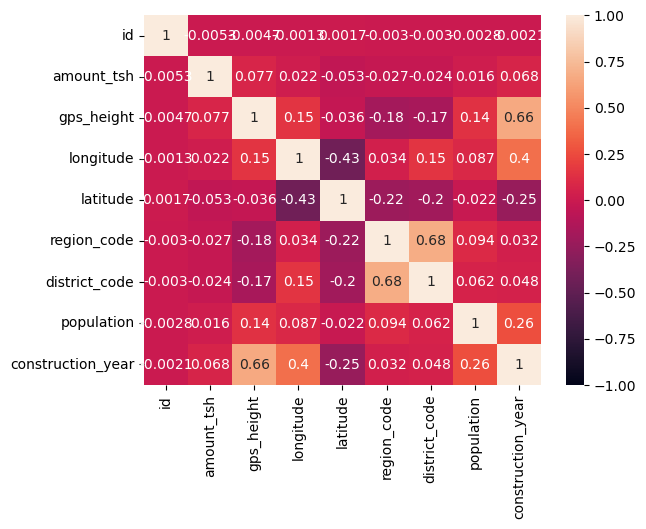

In [102]:
train = train_values.merge(train_labels, on="id")

# sns.pairplot(train.sample(1000),kind="scatter")
# commented out the previous line because running all with this line is very slow

sns.heatmap(data=train.corr(), vmin=-1, vmax=1, annot=True)


There is not much useful correlations inbetween the numerical features

Including population and amount of tsh

## Question: Does construction year have some correlation with pump status?


Earliest construction year excluding year 0:

In [103]:
train.construction_year[lambda x: x > 0].sort_values().head(1)


4562    1960
Name: construction_year, dtype: int64

In [104]:
g = train.groupby(by=["construction_year", "status_group"]
                  ).size().reset_index()

g.head()

# plt.plot(g)
# fig,ax = plt.subplot(1,3,1,sharex=True,sharey=True)

# ax.hist(g,range=(1960,g.max()))
# # ax.set()
# plt.show()

# plt.plot(g)


,construction_year,status_group,0
0,0,functional,10555
1,0,functional needs repair,1789
2,0,non functional,8365
3,1960,functional,24
4,1960,functional needs repair,6
